Latihan:   
* https://www.kaggle.com/jessemostipak/hotel-booking-demand    
* https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists  
* https://www.kaggle.com/blastchar/telco-customer-churn

Pilih salah satu dari dataset di atas:  
* Lakukan EDA singkat sebagai basis dari skema preprocessing kalian  
* Tentukan metric evaluasi sesuai dengan tujuan bisnis kalian. 
* Pilih model terbaik dari model klasifikasi yang sudah kita pelajari (dt, knn, logreg, ensemble)
* Optimasi model yang kalian pilih (hyperparameter tunning, kalau dataset imbalance, bisa pakai balancing method)

Kirim link github ke Brigita.gems@gmail.com

# Library

In [1]:
# basic data analysis dan visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')

# statistic
from scipy.stats import chi2_contingency

# preprocessing
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

# model classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# model selection & hyperparameter tuning
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# metric classification
from sklearn.metrics import recall_score, precision_score, classification_report, f1_score




# Dataset
**HR Analytics: Job Change of Data Scientists**\
Predict who will move to a new job 

In [2]:
df = pd.read_csv('aug_train.csv')
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

> Mayoritas data dalam bentuk categorical

In [4]:
df['target'].value_counts() / df.shape[0]*100

0.0    75.065247
1.0    24.934753
Name: target, dtype: float64

> terdapat imbalance data antara kelas 0 dan 1, dataset yang dimiliki terdiri dari 75% kelas 0 dan hanya 25% kelas 1

In [5]:
df['enrollee_id'].nunique() 


19158

> enrollee_id adalah data unik (id) untuk setiap pendaftar maka tidak akan kita pakai dalam pembuatan model

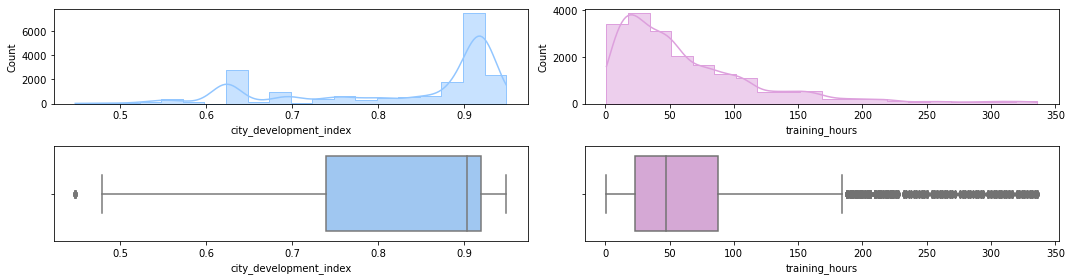

In [6]:
fig, axs = plt.subplots(2,2,figsize=(15,4))

sns.histplot(ax=axs[0,0], x=df['city_development_index'], kde=True, element="step", bins=20)
sns.histplot(ax=axs[0,1], x=df['training_hours'], kde=True, element="step", bins=20, color='plum')

sns.boxplot(ax=axs[1,0], x=df['city_development_index'])
sns.boxplot(ax=axs[1,1], x=df['training_hours'], color='plum')

axs[0,0].set_xlabel('city_development_index')
axs[0,1].set_xlabel('training_hours')
axs[1,0].set_xlabel('city_development_index')
axs[1,1].set_xlabel('training_hours')
plt.tight_layout()
plt.show()

In [7]:
df[['city_development_index', 'training_hours', 'target']].corr(method='spearman')

,city_development_index,training_hours,target
city_development_index,1.000000,0.007491,-0.279165
training_hours,0.007491,1.000000,-0.014126
target,-0.279165,-0.014126,1.000000


> * city_development_index & training_hours memiliki distribusi data tidak normal
> * terdapat banyak outlier didalam data training_hours
> * ada hubungan yang lemah diantara city_development_index, training_hours & target

# Missing Value

In [8]:
df.isna().sum()/df.shape[0]*100

enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
last_new_job               2.207955
training_hours             0.000000
target                     0.000000
dtype: float64

> terdapat banyak missing value didalam dataset dan semuanya dalam bentuk data categorical 

In [9]:
for i in df.columns[df.dtypes==object]:
    print(f"{i} : {df[i].unique()}")

city : ['city_103' 'city_40' 'city_21' 'city_115' 'city_162' 'city_176'
 'city_160' 'city_46' 'city_61' 'city_114' 'city_13' 'city_159' 'city_102'
 'city_67' 'city_100' 'city_16' 'city_71' 'city_104' 'city_64' 'city_101'
 'city_83' 'city_105' 'city_73' 'city_75' 'city_41' 'city_11' 'city_93'
 'city_90' 'city_36' 'city_20' 'city_57' 'city_152' 'city_19' 'city_65'
 'city_74' 'city_173' 'city_136' 'city_98' 'city_97' 'city_50' 'city_138'
 'city_82' 'city_157' 'city_89' 'city_150' 'city_70' 'city_175' 'city_94'
 'city_28' 'city_59' 'city_165' 'city_145' 'city_142' 'city_26' 'city_12'
 'city_37' 'city_43' 'city_116' 'city_23' 'city_99' 'city_149' 'city_10'
 'city_45' 'city_80' 'city_128' 'city_158' 'city_123' 'city_7' 'city_72'
 'city_106' 'city_143' 'city_78' 'city_109' 'city_24' 'city_134' 'city_48'
 'city_144' 'city_91' 'city_146' 'city_133' 'city_126' 'city_118' 'city_9'
 'city_167' 'city_27' 'city_84' 'city_54' 'city_39' 'city_79' 'city_76'
 'city_77' 'city_81' 'city_131' 'city_44' 'ci

> - `gender` isi dengan other di preprocessing
> - cek apakah `enrolled_university`, `education level` dan `major_discipline` berketerkaitan karena berhubungan dengan education
> - cek apakah `experience`, `company_size`, `company_type` dan `last_new_job` memiliki keterkaitan karena berhubungan dengan occupation

## Handling missing value di enrolled_university, education_level dan major_discipline

**Hypothesis**   
Ho : tidak ada keterkaitan diantara kedua variable\
Ha : ada keterkaitan diantara kedua variable

In [10]:
education_data = ['enrolled_university', 'education_level', 'major_discipline']
skip = []

for i in education_data:
    for j in education_data:
        if i == j or j in skip:
            continue
        else:
            stats, pval, dof, expected = chi2_contingency(pd.crosstab(df[i], df[j]))
            # conclusion
            if pval <= 0.05:
                print(f'Tolak Ho, {i} memiliki keterkaitan dengan {j}')
            else:
                print(f'Terima Ho, {i} tidak memiliki keterkaitan dengan {j}')
    skip.append(i)

Tolak Ho, enrolled_university memiliki keterkaitan dengan education_level
Tolak Ho, enrolled_university memiliki keterkaitan dengan major_discipline
Tolak Ho, education_level memiliki keterkaitan dengan major_discipline


In [11]:
uniqueEducationLevel = df['education_level'].dropna().unique()
for i in uniqueEducationLevel:
    print(df[df['education_level'] == i][['education_level', 'major_discipline']].mode())

  education_level major_discipline
0        Graduate             STEM
  education_level major_discipline
0         Masters             STEM
  education_level major_discipline
0     High School              NaN
  education_level major_discipline
0             Phd             STEM
  education_level major_discipline
0  Primary School              NaN


In [12]:
enrollModus = df[df['enrolled_university'] != 'no_enrollment']['enrolled_university'].mode()
lowEduModus = df[(df['education_level'] == 'Primary School') | 
   (df['education_level'] == 'High School') |
   (df['education_level'] == 'Graduate')
  ]['education_level'].mode()
highEduModus = df[(df['education_level'] == 'Masters') | 
   (df['education_level'] == 'Phd')
  ]['education_level'].mode()

print('Modus data jika tidak enroll:', enrollModus.item())
print('Modus data untuk level education sebelum universitas:', lowEduModus.item())
print('Modus data untuk level education didalam universitas:', highEduModus.item())

Modus data jika tidak enroll: Full time course
Modus data untuk level education sebelum universitas: Graduate
Modus data untuk level education didalam universitas: Masters


berdasarkan analisa diatas, kita dapat menyiasati missing value sebagai berikut:

**enrolled_university** 
1. isi dengan 'no_enrollment' jika education_level adalah Primary School / High School / Graduate
2. isi dengan 'Full time course' (dari modus) jika education_level salah satu dari 'Masters', 'Phd' atau major_discipline salah satu dari 'STEM', 'Business Degree', 'Arts', 'Humanities', 'Other'
3. isi sisanya dengan constant N 

**education_level**
1. isi dengan 'Masters' (dari modus) jika enrolled_university adalah Full time course/Part time course
2. isi dengan 'Graduate' (dari modus) jika enrolled_university adalah no_enrollment
3. isi sisanya dengan constant N

**major_discipline**
1. isi dengan STEM (dari modus) jika education_level Masters / Phd
2. isi dengan No Major jika education level Primary School / High School / Graduate
2. isi sisanya dengan constant N

In [13]:
lowEdu = ['Primary School', 'High School', 'Graduate']
highEdu = ['Masters', 'Phd']

def fillEnrolledUniversity(x):
    if x['enrolled_university'] is np.nan:
        if x['education_level'] in lowEdu:
            x['enrolled_university'] = 'no_enrollment'
        elif (x['education_level'] in highEdu) or (x['major_discipline'] in ['STEM', 'Business Degree', 'Arts', 'Humanities', 'Other']):
             x['enrolled_university'] = 'Full time course'
        else: 
             x['enrolled_university'] = 'N'
    return x

def fillEducationLevel(x):
    if x['education_level'] is np.nan:
        if x['enrolled_university'] in ['Full time course', 'Part time course']:
            x['education_level'] = 'Masters'
        elif x['enrolled_university'] == 'no_enrollment':
            x['education_level'] = 'Graduate'
        else: 
            x['education_level'] = 'N'
    return x

def fillMajorDiscipline(x):
    if x['major_discipline'] is np.nan:
        if x['education_level'] in highEdu:
            x['major_discipline'] = 'STEM'
        elif x['education_level'] in lowEdu:
            x['major_discipline'] = 'No Major'
        else: 
            x['major_discipline'] = 'N'
    return x


In [14]:
df['enrolled_university'] = df[education_data].apply(fillEnrolledUniversity, axis=1)

In [15]:
df['education_level'] = df[education_data].apply(fillEducationLevel, axis=1)

In [16]:
df['major_discipline'] = df[education_data].apply(fillMajorDiscipline, axis=1)

## Handling Missing Value in company_type, company_size, last_new_job dan experience

**Hypothesis**   
Ho : tidak ada keterkaitan diantara kedua variable\
Ha : ada keterkaitan diantara kedua variable

In [17]:
company_data = ['company_size', 'company_type', 'last_new_job']
skip = []

for i in company_data:
    for j in company_data:
        if i == j or j in skip:
            continue
        else:
            stats, pval, dof, expected = chi2_contingency(pd.crosstab(df[i], df[j]))
            # conclusion
            if pval <= 0.05:
                print(f'Tolak Ho, {i} memiliki keterkaitan dengan {j}')
            else:
                print(f'Terima Ho, {i} tidak memiliki keterkaitan dengan {j}')
    skip.append(i)

Tolak Ho, company_size memiliki keterkaitan dengan company_type
Tolak Ho, company_size memiliki keterkaitan dengan last_new_job
Tolak Ho, company_type memiliki keterkaitan dengan last_new_job


In [18]:
uniqueLastNewJob = df['last_new_job'].dropna().unique()
for i in uniqueLastNewJob:
    print(df[df['last_new_job'] == i][company_data].mode())
    

  company_size company_type last_new_job
0        50-99      Pvt Ltd            1
  company_size company_type last_new_job
0      100-500      Pvt Ltd           >4
  company_size company_type last_new_job
0        50-99      Pvt Ltd        never
  company_size company_type last_new_job
0        50-99      Pvt Ltd            4
  company_size company_type last_new_job
0        50-99      Pvt Ltd            3
  company_size company_type last_new_job
0        50-99      Pvt Ltd            2


In [19]:
df['last_new_job'].mode()

0    1
dtype: object

dari data diatas kita dapat menyiasati missing value untuk variable `company_size`, `company_type`, `last_new_job` sebagai berikut
1. isi company_size	& company_type dengan constant 'N' jika last_new_job memiliki value never untuk menandai pendaftar yang belum bekerja
2. isi company_size, company_type & last_new_job dengan constant 'N' jika ketiganya NaN untuk menandai pendaftar yang belum bekerja
3. company_type yang nan diisi dengan 'Pvt Ltd' (hasil modus)
4. company_size yang nan diisi dengan 100-500 jika last_new_job >4 dan 50-99 untuk yang lain (hasil modus)
5. last_new_job diisi dengan 1 (hasil modus)

In [20]:
def fillCompanyData(x):
    if (x['last_new_job'] == 'never' and x['company_size'] is np.nan and x['company_type'] is np.nan) or (x.isna().sum() == 3):
        return x.fillna('N')
    else:
        if x['company_type'] is np.nan:
            x['company_type'] = 'Pvt Ltd'
        if x['company_size'] is np.nan:
            x['company_size'] = '100-500' if x['last_new_job'] == '>4' else '50-99'
        if x['last_new_job'] is np.nan:
            x['last_new_job'] = '1'
        
        return x

df[company_data] = df[company_data].apply(fillCompanyData, axis=1)

**Hypothesis**   
Ho : tidak ada keterkaitan diantara variable experience dan last_new_job\
Ha : ada keterkaitan diantara variable experience dan last_new_job

In [21]:
i = 'last_new_job'
j = 'experience'

stats, pval, dof, expected = chi2_contingency(pd.crosstab(df[i], df[j]))
# conclusion
if pval <= 0.05:
    print(f'Tolak Ho, {i} memiliki keterkaitan dengan {j}')
else:
    print(f'Terima Ho, {i} tidak memiliki keterkaitan dengan {j}')

Tolak Ho, last_new_job memiliki keterkaitan dengan experience


In [22]:
uniqueLastNewJob = df['last_new_job'].dropna().unique()
for i in uniqueLastNewJob:
    print(df[df['last_new_job'] == i][['experience', 'last_new_job']].mode())

  experience last_new_job
0        >20            1
  experience last_new_job
0        >20           >4
  experience last_new_job
0          3        never
  experience last_new_job
0        >20            4
  experience last_new_job
0        >20            3
  experience last_new_job
0        >20            2
  experience last_new_job
0          3            N


dari data diatas kita dapat menyiasati missing value untuk variable `experience` sebagai berikut:
* jika last_new_job never atau n, maka diisi dengan 3 selain itu diisi dengan >20

In [23]:
def fillExperience(x):
    if x['experience'] is np.nan:
        x['experience'] = '3' if x['last_new_job'] in ['never', 'n'] else '>20'
    return x

df['experience'] = df[['experience', 'last_new_job']].apply(fillExperience, axis=1)

In [24]:
df.isna().sum()/df.shape[0]*100

enrollee_id                0.00000
city                       0.00000
city_development_index     0.00000
gender                    23.53064
relevent_experience        0.00000
enrolled_university        0.00000
education_level            0.00000
major_discipline           0.00000
experience                 0.00000
company_size               0.00000
company_type               0.00000
last_new_job               0.00000
training_hours             0.00000
target                     0.00000
dtype: float64

# Preprocessing

x : semua feature kecuali enrollee_id\
y : target

skema:
1. imputer constant, one hot encoding : gender, relevent_experience, enrolled_university
2. ordinal encoding : education_level, experience, last_new_job
3. binary encoding : city, major_discipline, company_size, company_type
4. robust scaler : city_development_index, training_hours
5. remainder : passthrough


In [25]:
# One Hot Pipeline
onehot_pipe = Pipeline([
    ('modus imputer', SimpleImputer(strategy='constant', fill_value='Other')),
    ('one hot encoder', OneHotEncoder(drop='first'))
])

In [26]:
df['last_new_job'].value_counts()

1        8270
>4       3290
2        2900
never    2452
4        1029
3        1024
N         193
Name: last_new_job, dtype: int64

In [27]:
# ordinal mapping functions
def map_experience():
    dictexp =  {None:0}
    for i in df['experience'].unique():
        if (i == '<1'):
            dictexp[i] = 0
        elif(i == '>20'):
            dictexp[i] = 21
        else:
            dictexp[i] = int(i)
    return dictexp

def map_lastnewjob():
    dictexp =  {None:0}
    for i in df['last_new_job'].unique():
        if (i == '>4'):
            dictexp[i] = 5
        elif(i == 'never' or i == 'N'):
            dictexp[i] = 0
        else:
            dictexp[i] = int(i)
    return dictexp

In [28]:
# Ordinal Mapping
ordinal_mapping = [
    {
        'col': 'education_level',
        'mapping': {None:0, 'N':0, 'no_enrollment': 1, 'Full time course':2, 'Part time course':3}
    }, 
    {
        'col': 'experience',
        'mapping': map_experience()
    }, 
    {
        'col': 'last_new_job',
        'mapping': map_lastnewjob()
    }
]

In [29]:
transformer = ColumnTransformer([
    ('one hot encoding', onehot_pipe, ['gender', 'relevent_experience', 'enrolled_university']),
    ('ordinal encoding', ce.OrdinalEncoder(mapping=ordinal_mapping), ['education_level', 'experience', 'last_new_job']),
    ('binary encoding', ce.BinaryEncoder(), ['city', 'major_discipline', 'company_size', 'company_type']),
    ('Robust Scaler', RobustScaler(), ['city_development_index', 'training_hours'])
], remainder='passthrough')

In [30]:
transformer.fit_transform(df.drop(columns=['enrollee_id', 'target']))

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.09444444, -0.16923077],
       [ 1.        ,  0.        ,  1.        , ...,  1.        ,
        -0.70555556,  0.        ],
       [ 0.        ,  1.        ,  1.        , ...,  0.        ,
        -1.55      ,  0.55384615],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.09444444, -0.04615385],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
        -0.56111111,  0.76923077],
       [ 0.        ,  1.        ,  1.        , ...,  1.        ,
        -0.26666667,  1.23076923]])

# Splitting Data

In [31]:
x = df.drop(columns=['enrollee_id', 'target'])
y = df['target']

In [32]:
df['target'].value_counts() / df.shape[0] * 100

0.0    75.065247
1.0    24.934753
Name: target, dtype: float64

> terdapat imbalance data, dimana data terdiri dari 75% kelas 0 dan 25% kelas 1

In [33]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    stratify=y,
    random_state=2020
)

# Benchmark

## Confusion Matrix

|                              	| Not looking for job change                                                               	| Looking for a job change                                                            	|
|------------------------------	|------------------------------------------------------------------------------------------	|-------------------------------------------------------------------------------------	|
| Not looking for job change   	| TRUE NEGATIVE<br>enrollee yang tidak ingin pindah kerja<br>diprediksi tidak pindah kerja 	| FALSE POSITIVE<br>enrollee yang tidak ingin pindah kerja<br>diprediksi pindah kerja 	|
| <br>Looking for a job change 	| FALSE NEGATIVE<br>enrollee yang ingin pindah kerja<br>diprediksi tidak pindah kerja      	| TRUE POSITIVE<br>enrollee yang ingin pindah kerja<br>diprediksi ingin pindah kerja  	|

Dampak FALSE POSITIVE : melakukan follow up kepada enrollee yang tidak ingin pindah kerja\
Dampak FALSE NEGATIVE : kehilangan kandidat yang ingin bekerja di perusahaan

untuk mengoptimalisasi prediksi kandidat yang ingin bekerja di perusahaan, maka perlu meminimalisir prediksi **FALSE NEGATIVE** maka digunakan **RECALL Scoring**

tetapi karena label (data target) imbalance kita bisa gunakan **F1-Score**

## Cross Validation

In [34]:
models = [
    LogisticRegression(solver='liblinear', class_weight='balanced', random_state=2020), 
    KNeighborsClassifier(), 
    DecisionTreeClassifier(random_state=2020, max_depth=3),
    RandomForestClassifier(n_estimators=20, max_depth=3, random_state=2020)
]
cv_score = []
cv_mean = []
cv_std = []

for i in models:
    skfold = StratifiedKFold(n_splits=5)
    estimator = Pipeline([
        ('preprocess', transformer),
        ('model', i)
    ])

    model_cv = cross_val_score(estimator, x_train, y_train, cv=skfold, scoring='f1')
    cv_score.append(model_cv)
    cv_mean.append(model_cv.mean())
    cv_std.append(model_cv.std())

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/anaconda3/lib/python3.8/site-packages/category_encoders

In [35]:
pd.DataFrame({
    'model': ['logreg', 'knn', 'tree', 'rf'],
    'score': cv_score,
    'mean': cv_mean,
    'std': cv_std
})

,model,score,mean,std
0,logreg,"[0.5339524085896692, 0.552414605418139, 0.5574...",0.542664,0.010210
1,knn,"[0.4163454124903624, 0.4498852333588371, 0.428...",0.427271,0.012419
2,tree,"[0.4784688995215311, 0.49877750611246946, 0.49...",0.489008,0.015518
3,rf,"[0.37183098591549296, 0.26609442060085836, 0.2...",0.298577,0.041645


> dari cross validation diatas, logreg memiliki rata-rata paling tinggi dan nilai std yang cukup stabil

## Hyperparameter Tuning

In [36]:
logreg = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=2020)
estimator = Pipeline([
    ('preprocess', transformer),
    ('model', logreg)
])

In [37]:
# estimator.get_params()

In [38]:
hyperparam_space = {
    'model__C': [1000, 100, 10, 1, 0.1, 0.01, 0.001], # benchmark 1
    'model__solver': ['liblinear', 'newton-cg'], # benchmark liblinear
    'model__max_iter': [50, 75, 100, 250, 500, 750], # benchmark 100
}

In [39]:
skfold = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(
    estimator,
    param_grid = hyperparam_space,
    cv = skfold,
    scoring='f1',
    n_jobs=-1
)

In [40]:
grid_search.fit(x_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot '
                                                                         'encoding',
                                                                         Pipeline(steps=[('modus '
                                                                                          'imputer',
                                                                                          SimpleImputer(fill_value='Other',
                                                                                                        strategy='constant')),
                                                                                        

In [41]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.5454252664096301
{'model__C': 0.1, 'model__max_iter': 50, 'model__solver': 'newton-cg'}


## Before and After Tuning

In [42]:
# Before 
logreg = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=2020)
estimator = Pipeline([
    ('preprocess', transformer),
    ('model', logreg)
])
estimator.fit(x_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoding',
                                                  Pipeline(steps=[('modus '
                                                                   'imputer',
                                                                   SimpleImputer(fill_value='Other',
                                                                                 strategy='constant')),
                                                                  ('one hot '
                                                                   'encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['gender',
                                                   'relevent_experience',
                                                   'enrolled_university']),
              

In [43]:
y_pred = estimator.predict(x_test)
cw_f1_score = f1_score(y_test, y_pred)
cw_classification_report = classification_report(y_test, y_pred)
print(cw_f1_score)
print(cw_classification_report)


0.5378681626928471
              precision    recall  f1-score   support

         0.0       0.86      0.75      0.80      3596
         1.0       0.46      0.64      0.54      1194

    accuracy                           0.72      4790
   macro avg       0.66      0.70      0.67      4790
weighted avg       0.76      0.72      0.74      4790



In [44]:
# After
best_model = grid_search.best_estimator_
best_model.fit(x_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoding',
                                                  Pipeline(steps=[('modus '
                                                                   'imputer',
                                                                   SimpleImputer(fill_value='Other',
                                                                                 strategy='constant')),
                                                                  ('one hot '
                                                                   'encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['gender',
                                                   'relevent_experience',
                                                   'enrolled_university']),
              

In [45]:
y_pred_final = best_model.predict(x_test)
cwhs_f1_score = f1_score(y_test, y_pred_final)
cwhs_classification_report = classification_report(y_test, y_pred_final)
print(cwhs_f1_score)
print(cwhs_classification_report)

0.5391915641476274
              precision    recall  f1-score   support

         0.0       0.86      0.75      0.81      3596
         1.0       0.46      0.64      0.54      1194

    accuracy                           0.73      4790
   macro avg       0.66      0.70      0.67      4790
weighted avg       0.76      0.73      0.74      4790



> Setelah dilakukan hyperparameter tuning, terdapat peningkatan performa walaupun tidak signifikan dari 53.78% menjadi 53.91%

## Resampling SMOTE

In [46]:
transformer.fit(x_train)
x_train_preprocessed = transformer.fit_transform(x_train)
x_test_preprocessed = transformer.transform(x_test)


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### Cross Validation

In [47]:
from imblearn.pipeline import Pipeline as im_pipeline

In [48]:
models = [
    LogisticRegression(solver='liblinear', random_state=2020), 
    KNeighborsClassifier(), 
    DecisionTreeClassifier(random_state=2020, max_depth=3),
    RandomForestClassifier(n_estimators=20, max_depth=3, random_state=2020)
]
cv_score = []
cv_mean = []
cv_std = []

for i in models:
    skfold = StratifiedKFold(n_splits=5)
    estimator= im_pipeline([
        ('resampling', SMOTE(random_state=2020)),
        ('model',i)
    ])

    model_cv = cross_val_score(estimator, x_train_preprocessed, y_train, cv=skfold, scoring='f1')
    cv_score.append(model_cv)
    cv_mean.append(model_cv.mean())
    cv_std.append(model_cv.std())

In [49]:
pd.DataFrame({
    'model': ['logreg', 'knn', 'tree', 'rf'],
    'score': cv_score,
    'mean': cv_mean,
    'std': cv_std
})

,model,score,mean,std
0,logreg,"[0.5364161849710983, 0.5514834205933683, 0.545...",0.542282,0.005633
1,knn,"[0.4605329311211664, 0.4883040935672514, 0.491...",0.476641,0.014396
2,tree,"[0.4789180588703262, 0.49443561208267095, 0.49...",0.492720,0.009696
3,rf,"[0.5318302387267904, 0.5415512465373961, 0.556...",0.536054,0.011978


> dari cross validation diatas, logreg memiliki rata-rata paling tinggi dan nilai std yang cukup stabil

### Hyperparameter Tuning

In [50]:
logreg = LogisticRegression(solver='liblinear', random_state=2020)
estimator= im_pipeline([
    ('resampling', SMOTE(random_state=2020)),
    ('model', logreg)
])

In [51]:
#estimator.get_params()

In [52]:
hyperparam_space

{'model__C': [1000, 100, 10, 1, 0.1, 0.01, 0.001],
 'model__solver': ['liblinear', 'newton-cg'],
 'model__max_iter': [50, 75, 100, 250, 500, 750]}

In [53]:
skfold = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(
    estimator,
    param_grid = hyperparam_space,
    cv = skfold,
    scoring='f1',
    n_jobs=-1
)

In [54]:
grid_search.fit(x_train_preprocessed, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('resampling', SMOTE(random_state=2020)),
                                       ('model',
                                        LogisticRegression(random_state=2020,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'model__C': [1000, 100, 10, 1, 0.1, 0.01, 0.001],
                         'model__max_iter': [50, 75, 100, 250, 500, 750],
                         'model__solver': ['liblinear', 'newton-cg']},
             scoring='f1')

In [55]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.5422823791205603
{'model__C': 1, 'model__max_iter': 50, 'model__solver': 'liblinear'}


## Before and After Hyperparameter Tuning

In [56]:
# before tuning
logreg = LogisticRegression(solver='liblinear', random_state=2020)
estimator= im_pipeline([
    ('resampling', SMOTE(random_state=2020)),
    ('model', logreg)
])
estimator.fit(x_train_preprocessed, y_train)

Pipeline(steps=[('resampling', SMOTE(random_state=2020)),
                ('model',
                 LogisticRegression(random_state=2020, solver='liblinear'))])

In [57]:
y_pred_sm = estimator.predict(x_test_preprocessed)
sm_f1_score = f1_score(y_test, y_pred_sm)
sm_classification_report = classification_report(y_test, y_pred_sm)
print(sm_f1_score)
print(sm_classification_report)

0.5392088827203331
              precision    recall  f1-score   support

         0.0       0.87      0.75      0.80      3596
         1.0       0.46      0.65      0.54      1194

    accuracy                           0.72      4790
   macro avg       0.66      0.70      0.67      4790
weighted avg       0.76      0.72      0.74      4790



In [58]:
# after tuning
best_model = grid_search.best_estimator_
best_model.fit(x_train_preprocessed, y_train)

Pipeline(steps=[('resampling', SMOTE(random_state=2020)),
                ('model',
                 LogisticRegression(C=1, max_iter=50, random_state=2020,
                                    solver='liblinear'))])

In [59]:
y_pred_sm_final = best_model.predict(x_test_preprocessed)
smhs_f1_score = f1_score(y_test, y_pred_sm_final)
smhs_classification_report = classification_report(y_test, y_pred_sm_final)
print(smhs_f1_score)
print(smhs_classification_report)

0.5392088827203331
              precision    recall  f1-score   support

         0.0       0.87      0.75      0.80      3596
         1.0       0.46      0.65      0.54      1194

    accuracy                           0.72      4790
   macro avg       0.66      0.70      0.67      4790
weighted avg       0.76      0.72      0.74      4790



> tidak ada peningkatan performa setelah hypertuning, karena model yang digunakan untuk benchmark sama dengan model dari hasil hyperparameter tuning

# Comparing Model

In [60]:
pd.options.display.max_colwidth = None
pd.DataFrame({
    'model': [
        'Log Regression with class_weight', 
        'Log Regression with class_weight & hyperparam tuning',
        'Log Regression with smote', 
        'Log Regression with smote & hyperparam tuning',
    ],
    'F1 Score': [cw_f1_score, cwhs_f1_score, sm_f1_score, smhs_f1_score]
})

,model,F1 Score
0,Log Regression with class_weight,0.537868
1,Log Regression with class_weight & hyperparam tuning,0.539192
2,Log Regression with smote,0.539209
3,Log Regression with smote & hyperparam tuning,0.539209


> dari tabel diatas, dapat kita lihat bahwa Log Regression menggunakan SMOTE memiliki performa yang lebih tinggi walaupun tidak signifikan dibandingkan dengan Log Regression dengan menggunakan param class_weight